[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=lab/tree/PySDM_examples/Alpert_and_Knopf_2016/fig_1.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Alpert_and_Knopf_2016/fig_1.ipynb)

#### based on Fig. 1 from Alpert and Knopf 2016 (Atmos. Chem. Phys. 16) "_Analysis of isothermal and cooling-rate-dependent immersion freezing by a unifying stochastic ice nucleation model_"
https://doi.org/10.5194/acp-16-2083-2016

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet --use-deprecated=legacy-resolver install \
            PySDM-examples \
            notebook==`python -c "import notebook; print(notebook.__version__)"` \
            tornado==`python -c "import tornado; print(tornado.version)"`
    !ldconfig

In [5]:
from PySDM_examples.utils.show_plot import show_plot
from PySDM.backends import CPU
from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Freezing
from PySDM.physics import si, constants as const, Formulae
from PySDM.initialisation.multiplicities import discretise_n
from PySDM.initialisation import spectral_sampling
from PySDM.physics.spectra import Lognormal
from PySDM.products import IceWaterContent
import numpy as np
from matplotlib import pylab

In [16]:
J_het = 1e3 / si.cm**2 / si.s
A_g = 1e-5 * si.cm**2

multiplicity = 1
dt = 1 * si.s
total_time = 6 * si.min
n_runs_per_case = 10

# dummy multipliers (multiplied and then divided by)
dv = 1 * si.cm**3 # will become used if coalescence or other processes are turned on
droplet_volume = 1 * si.um**3 # ditto

cases = {
    'Iso3': {'ISA': Lognormal(norm_factor=1000/dv, m_mode=A_g, s_geom=10), 'color':'#1A62B4'},
    'Iso4': {'ISA': Lognormal(norm_factor=30/dv,   m_mode=A_g, s_geom=10), 'color':'#95BDE1'},
    'Iso1': {'ISA': Lognormal(norm_factor=1000/dv, m_mode=A_g, s_geom=1),  'color':'#298131'},
    'Iso2': {'ISA': Lognormal(norm_factor=30/dv,   m_mode=A_g, s_geom=1),  'color':'#9ACFA4'},
}

In [17]:
output = {}

for key, case in cases.items():
    output[key] = []
    for _ in range(n_runs_per_case):
        number_of_real_droplets = case['ISA'].norm_factor * dv
        n_sd = number_of_real_droplets / multiplicity
        assert int(n_sd) == n_sd
        n_sd = int(n_sd)

        formulae = Formulae(seed=_)        
        builder = Builder(n_sd=n_sd, backend=CPU, formulae=formulae)
        builder.set_environment(Box(dt=dt, dv=dv))
        builder.add_dynamic(Freezing(singular=False, J_het=J_het))

        if case['ISA'].s_geom != 1:
            _isa, _conc = spectral_sampling.ConstantMultiplicity(case['ISA']).sample(n_sd)
        else:
            _isa, _conc = np.full(n_sd, A_g), np.full(n_sd, multiplicity / dv)
        attributes = {
            'n': discretise_n(_conc * dv),
            'immersed surface area': _isa,
            'volume': np.full(n_sd, droplet_volume)
        }
        np.testing.assert_almost_equal(attributes['n'], multiplicity)
        products = (IceWaterContent(specific=False),)
        particulator = builder.build(attributes=attributes, products=products)

        cell_id = 0
        data = []
        for i in range(int(total_time / dt) + 1):
            particulator.run(0 if i == 0 else 1)

            ice_mass_per_volume = particulator.products['qi'].get()[cell_id]
            ice_mass = ice_mass_per_volume * dv
            ice_number = ice_mass / (const.rho_w * droplet_volume)
            unfrozen_fraction = 1 - ice_number / number_of_real_droplets
            data.append(unfrozen_fraction)

        output[key].append(data)

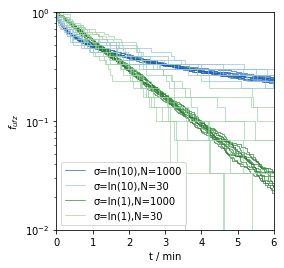

HTML(value="<a href='./tmp55x8g76b.pdf' target='_blank'>./tmp55x8g76b.pdf</a><br>")

In [20]:
pylab.rc('font', size=10)
for key in output.keys():
    for run in range(n_runs_per_case):
        label = f"σ=ln({int(cases[key]['ISA'].s_geom)}),N={int(cases[key]['ISA'].norm_factor*dv)}"
        pylab.step(
            dt / si.min * np.arange(len(output[key][run])),
            output[key][run],
            label=label if run == 0 else None,
            color=cases[key]['color'],
            linewidth=.666
        )

pylab.legend()
pylab.yscale('log')
pylab.ylim(1e-2, 1)
pylab.xlim(0, total_time / si.min)
pylab.xlabel("t / min")
pylab.ylabel("$f_{ufz}$")
pylab.gca().set_aspect(3)
show_plot()